In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import warnings 
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv(r'Taxi-cancellation-case.csv')

In [4]:
df['Car_Cancellation'].sum()/len(df)

0.0743

Tỉ lệ xe bị bỏ chuyến đang ở mức trung bình 7.43% trong số lượng quan sát

In [5]:
#drop hai column thông tin không cần thiết là row# và user_id
df.drop(columns = ['row#','user_id'], axis = 1, inplace = True)

## Nội dung

- <a href='#1'>1. Convert dữ liệu tọa độ, thời gian và check missing data</a>

- <a href='#2'>2. Làm rõ mối tương quan giữa area và city </a>  
   
- <a href='#3'>3. Encoding biến package_id và vehicle_type_id </a>
   
- <a href='#4'>4. Xử lý các thuộc tính về thời gian </a>

- <a href='#5'>5. Xử lý tiếp các thuộc tính về tọa độ </a>

- <a href='#6'>6. Chuẩn hóa các biến về số, xử lý outlier </a>

- <a href='#7'>7. Mô hình dự đoán với RandomForest</a>

- <a href='#8'>8. Mô hình dự đoán với AdaBoost </a> 

- <a href='#9'>9. Mô hình dự đoán với Lightgbm </a>


# <a id= '1'>1. Convert dữ liệu tọa độ, thời gian và check missing data</a>

Trước khi đi vào sử lý dữ liệu, chúng ta thấy có hai vấn đề cơ bản đối với tập thông tin này. Vấn đề thứ nhất là các thông tin về ngày tháng đang ở trong định dạng của excel, và thông tin về tọa độ. Trước hết chúng ta convert thông tin về ngày tháng sang định dạng datetime mà chúng ta có thể hiểu được.

In [6]:
# convert data to normal datetime data

def datetime_convert(data):
    data['from_date_'] = pd.to_datetime(df['from_date'])
    data['to_date_'] = pd.to_datetime(df['to_date'])
    data['booking_created_'] = pd.to_datetime(df['booking_created'])
    data.drop(columns = ['from_date','to_date','booking_created'], axis = 1, inplace = True)
    return data

datetime_convert(df)
df[['from_date_','to_date_','booking_created_']].head()

,from_date_,to_date_,booking_created_
0,2013-01-01 22:33:00,NaT,2013-01-01 08:01:00
1,2013-01-01 12:43:00,NaT,2013-01-01 09:59:00
2,2013-01-02 00:28:00,2013-01-03,2013-01-01 12:14:00
3,2013-01-01 13:12:00,NaT,2013-01-01 12:42:00
4,2013-01-01 16:33:00,NaT,2013-01-01 15:07:00


In [7]:
# convert về khoảng cách tính bằng km
def cordinate_convert(data):
    data['travel_dist'] = (np.sqrt((data['from_lat'] - data['to_lat'])**2 + (data['from_long'] - data['to_long'])**2))*111.32
    return data


cordinate_convert(df)
df.head()

,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,from_date_,to_date_,booking_created_,travel_dist
0,12,NaN,2,1021.0,1323.0,NaN,NaN,0,0,13.028530,77.54625,12.869805,77.653211,0,2013-01-01 22:33:00,NaT,2013-01-01 08:01:00,21.306741
1,12,NaN,2,455.0,1330.0,NaN,NaN,0,0,12.999874,77.67812,12.953434,77.706510,0,2013-01-01 12:43:00,NaT,2013-01-01 09:59:00,6.059189
2,12,NaN,2,814.0,393.0,NaN,NaN,1,0,12.908993,77.68890,13.199560,77.706880,0,2013-01-02 00:28:00,2013-01-03,2013-01-01 12:14:00,32.407786
3,12,NaN,2,297.0,212.0,NaN,NaN,0,0,12.997890,77.61488,12.994740,77.607970,0,2013-01-01 13:12:00,NaT,2013-01-01 12:42:00,0.845377
4,28,NaN,2,1237.0,330.0,NaN,NaN,0,0,12.926450,77.61206,12.858833,77.589127,0,2013-01-01 16:33:00,NaT,2013-01-01 15:07:00,7.948265


In [8]:
#check missing data
def missing_table(data):
    missing_var = data.isnull().sum()
    missing_percent = data.isnull().sum()/len(data)
    missing_table = pd.concat([missing_var, missing_percent], axis =1 )
    missing_table = missing_table.rename(columns = {0 :'Total missing', 1:'Missing percent'})
    missing_table = missing_table[missing_table['Missing percent'] != 0].sort_values('Missing percent', ascending=False)
    return missing_table

missing_table(df)

,Total missing,Missing percent
to_city_id,9661,0.9661
package_id,8248,0.8248
from_city_id,6294,0.6294
to_date_,4178,0.4178
to_area_id,2091,0.2091
to_lat,2091,0.2091
to_long,2091,0.2091
travel_dist,2091,0.2091
from_area_id,15,0.0015
from_lat,15,0.0015


Nhận xét:
* 1. Số lượng missing của tọa độ đến và đi trùng lặp với số lượng missing của area đến và đi
* 2. Ba trường thông tin có số lượng missing nhiều nhất là to_city_id, package_id, from_city_id


Trước hết về số lượng missing của tọa độ đến và đi trùng lặp với số lượng missing của area đến và đi. Chúng ta có thể tạm đưa ra giả định là hệ thống xác định area ID dựa trên tọa độ, trong trường hợp không có tọa độ, ID này sẽ bị missing.

In [9]:
print(df['from_area_id'][df['from_lat'].isnull()].notnull().sum(),
      df['from_lat'][df['from_area_id'].isnull()].notnull().sum())

0 0


In [10]:
print(df['to_area_id'][df['to_lat'].isnull()].notnull().sum(),
      df['to_lat'][df['to_area_id'].isnull()].notnull().sum())

0 0


Lệnh trên trả về số lượng dữ liệu trong đó số liệu về tọa độ missing nhưng số liệu về ID area không missing. Kết quả kiểm tra đối với from_area và to_area đều là 0. Như vậy trong trường dữ liệu của chúng ta, tất cả dữ liệu có thông tin về tọa độ, đều có thông tin về area ID và ngược lại.

In [11]:
df[df['from_lat'].isnull()]

,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,from_date_,to_date_,booking_created_,travel_dist
1449,54,NaN,1,NaN,NaN,15.0,32.0,1,0,NaN,NaN,NaN,NaN,0,2013-03-09 19:26:00,2013-03-10 00:00:00,2013-03-09 16:24:00,NaN
1959,12,NaN,1,NaN,NaN,15.0,29.0,1,0,NaN,NaN,NaN,NaN,0,2013-04-04 14:09:00,2013-04-05 00:00:00,2013-04-04 10:59:00,NaN
2441,28,NaN,1,NaN,NaN,15.0,146.0,0,0,NaN,NaN,NaN,NaN,0,2013-04-26 17:02:00,2013-04-27 17:00:00,2013-04-25 22:17:00,NaN
3961,13,NaN,1,NaN,NaN,15.0,29.0,1,0,NaN,NaN,NaN,NaN,0,2013-06-12 17:02:00,2013-06-13 00:00:00,2013-06-12 13:46:00,NaN
3970,65,NaN,1,NaN,NaN,15.0,55.0,1,0,NaN,NaN,NaN,NaN,0,2013-06-12 22:19:00,2013-06-13 00:00:00,2013-06-12 19:05:00,NaN
4222,24,NaN,1,NaN,NaN,15.0,146.0,1,0,NaN,NaN,NaN,NaN,0,2013-06-21 22:48:00,2013-06-22 00:00:00,2013-06-21 19:38:00,NaN
4725,12,NaN,1,NaN,NaN,15.0,32.0,0,0,NaN,NaN,NaN,NaN,0,2013-07-07 07:55:00,2013-07-07 00:00:00,2013-07-06 22:34:00,NaN
5114,12,NaN,1,NaN,NaN,15.0,32.0,1,0,NaN,NaN,NaN,NaN,0,2013-07-19 00:57:00,2013-07-19 23:59:00,2013-07-18 21:58:00,NaN
5141,12,NaN,1,NaN,NaN,15.0,29.0,1,0,NaN,NaN,NaN,NaN,0,2013-07-19 18:14:00,2013-07-20 23:59:00,2013-07-19 15:29:00,NaN
5160,12,NaN,1,NaN,NaN,15.0,32.0,1,0,NaN,NaN,NaN,NaN,0,2013-07-20 00:57:00,2013-07-20 23:59:00,2013-07-19 21:44:00,NaN


Trường dữ liệu tọa độ điểm đi là trường thông tin missing thấp nhấp, chỉ có 15 missing trên 10000 điểm dữ liệu.Hơn nữa, hầu hết các thông tin missing này chỉ xảy ra đối với travel_type_id là 1. Do dữ liệu missing ở thuộc tính tọa độ điểm đi này rất ít, cũng như chỉ xảy ra đối với travel type là 1, tạm coi như đây là lỗi hệ thống, và việc dữ liệu missing này sẽ không làm ảnh hưởng đến tập dữ liệu.

In [12]:
df = df[df['from_lat'].notnull()]

# <a id = '2'> 2. Làm rõ mối tương quan giữa city và area </a>

In [13]:
df[['from_city_id','to_city_id','from_area_id','to_area_id']].astype('category').describe()

,from_city_id,to_city_id,from_area_id,to_area_id
count,3691.0,324.0,9985.0,7909.0
unique,2.0,66.0,522.0,479.0
top,15.0,32.0,393.0,393.0
freq,3664.0,101.0,897.0,2015.0


Từ thông tin tọa độ điểm đón xe, mọi tài xế đều có khả năng phán đoán được họ sẽ phải đón ở thành phố nào. Thông tin from_city_id là thông tin không cần thiết đối với quá trình ra quyết định của tài xế, có thể drop thuộc tính này.  

In [14]:
df.drop(columns = 'from_city_id', inplace = True)

print(df['to_city_id'][df['to_area_id'].notnull()].notnull().sum(),
      df['to_city_id'][df['to_area_id'].isnull()].notnull().sum(),
      df['to_city_id'][df['to_area_id'].notnull()].isnull().sum(),
      df['to_city_id'][df['to_area_id'].isnull()].isnull().sum()
     )

Thuộc tính to_city_id có nhiều phân lớp hơn nhưng lại missing đến 96.6%. Xem xét mối quan hệ đối với thuộc tính to_area_id, thấy có 324 điểm dữ liệu trong đó tập dữ liệu không có thông tin về area ID nhưng lại có thông tin về city ID, và không có điểm dữ liệu nào chứa cả thông tin về area và city.

In [15]:
df[df['to_area_id'].isnull() & df['to_city_id'].notnull()].tail()

,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,to_city_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,from_date_,to_date_,booking_created_,travel_dist
9853,12,NaN,1,393.0,NaN,32.0,1,0,13.199560,77.70688,NaN,NaN,0,2013-04-27 08:09:00,2013-04-27 08:15:00,2013-04-26 22:13:00,NaN
9928,65,NaN,1,393.0,NaN,32.0,0,0,13.199560,77.70688,NaN,NaN,0,2013-02-20 00:14:00,2013-02-20 00:00:00,2013-02-19 14:18:00,NaN
9955,12,NaN,1,147.0,NaN,166.0,1,0,12.977544,77.66880,NaN,NaN,0,2013-10-12 06:00:00,NaT,2013-10-11 11:30:00,NaN
9970,12,NaN,1,1136.0,NaN,179.0,1,0,12.990490,77.69798,NaN,NaN,0,2013-01-12 01:55:00,2013-01-13 02:00:00,2013-01-10 15:59:00,NaN
9985,85,NaN,1,1286.0,NaN,61.0,1,0,12.973448,77.62032,NaN,NaN,0,2013-05-25 07:55:00,2013-05-26 08:00:00,2013-05-22 20:56:00,NaN


Đối với travel_type_id là 1, ta không có thông tin về nơi đến cụ thể (thông qua tọa độ điểm đến và to_area_id), thay vào đó là thông tin về thành phố đến. Và số lượng này bằng đúng con số 324. Có vẻ như dữ liệu về to_city_id và to_city_area còn phụ thuộc vào loại hình travel

In [16]:
df['travel_type_id'][df['travel_type_id'] == 1].count()

324

In [17]:
df[['travel_type_id','to_area_id','to_city_id']].groupby('travel_type_id').count()

,to_area_id,to_city_id
travel_type_id,,
1,0,324
2,7909,0
3,0,0


Tổng hợp nhận xét:
* Thuê xe đường dài (type 1): Không có data tọa độ, area ID điểm đến, có city ID điểm đến
* Thuê xe theo cuốc (type 2): Có tọa độ, area ID điểm đến, không có city ID điểm đến
* Thuê xe theo giờ (type 3): Không có bất kỳ dữ liệu về tọa độ, area ID, city ID

Có vẻ như dữ liệu là dữ liệu tổng hợp từ ba bảng khác nhau. Mỗi bảng là một loại hình travel và có cách ghi nhận điểm đến khách nhau

In [18]:
# tạo biến dummy cho ba loại hình thuê xe

dummy = pd.get_dummies(df['travel_type_id'])
dummy.rename(columns = {1: 'Long_travel', 2: 'PtP', 3:'Hourly'}, inplace = True)
dummy.fillna(0)
df_new = pd.concat([df,dummy], axis = 1)
df_new.head()

,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,to_city_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,from_date_,to_date_,booking_created_,travel_dist,Long_travel,PtP,Hourly
0,12,NaN,2,1021.0,1323.0,NaN,0,0,13.028530,77.54625,12.869805,77.653211,0,2013-01-01 22:33:00,NaT,2013-01-01 08:01:00,21.306741,0,1,0
1,12,NaN,2,455.0,1330.0,NaN,0,0,12.999874,77.67812,12.953434,77.706510,0,2013-01-01 12:43:00,NaT,2013-01-01 09:59:00,6.059189,0,1,0
2,12,NaN,2,814.0,393.0,NaN,1,0,12.908993,77.68890,13.199560,77.706880,0,2013-01-02 00:28:00,2013-01-03,2013-01-01 12:14:00,32.407786,0,1,0
3,12,NaN,2,297.0,212.0,NaN,0,0,12.997890,77.61488,12.994740,77.607970,0,2013-01-01 13:12:00,NaT,2013-01-01 12:42:00,0.845377,0,1,0
4,28,NaN,2,1237.0,330.0,NaN,0,0,12.926450,77.61206,12.858833,77.589127,0,2013-01-01 16:33:00,NaT,2013-01-01 15:07:00,7.948265,0,1,0


Biến travel_dist sẽ bị missing đối với loại hình travel 1 và 3. Ở đây sẽ thay thế biến missing bằng 0 với loại hình travel số 1, và biến missing là -1 đối với loại hình travel là 3.

In [19]:
df_new['travel_dist'][df_new['Long_travel'] == 1] = 0
df_new['travel_dist'][df_new['Hourly'] == 1] = -1
df_new.drop(columns = 'to_city_id', inplace = True)

In [20]:
missing_table(df_new)

,Total missing,Missing percent
package_id,8233,0.824537
to_date_,4178,0.418428
to_area_id,2076,0.207912
to_lat,2076,0.207912
to_long,2076,0.207912


# <a id = '3'> 3. Encoding biến package_id và vehicle_type_id</a>

Hiện gói package của chúng ta đang được đánh giá như sau:
<br>1=4hrs & 40kms, 2=8hrs & 80kms, 3=6hrs & 60kms, 4= 10hrs & 100kms, 5=5hrs & 50kms, 6=3hrs & 30kms, 7=12hrs & 120kms</br>
<br>Đối với biến category, thứ tự sắp xếp của phân lớp phải theo một quy luật nào đó. Thông thường thì các gói package cho các chuyến đi càng dài thì phải có khuyến mãi càng lớn. Thế nên cách sắp xếp category như trên có vẻ chưa được hợp lý. Cần thay thế giá trị category mới như sau</br>
<br>6 thay bằng 1</br>
<br>1 thay bằng 2</br>
<br>5 thay bằng 3</br>
<br>3 thay bằng 4</br>
<br>2 thay bằng 5</br>
<br>4 thay bằng 6</br>
<br>7 giữ nguyên, và thay thế các giá trị missing bởi 0</br>

In [21]:
df_new['package_id'].replace({6:1, 1:2, 5:3, 3:4, 2:5, 4:6, np.nan: 0}, inplace = True)
df_new['package_id'].astype(str).value_counts()

0.0    8233
2.0     800
5.0     659
1.0     104
6.0      84
4.0      82
7.0      22
3.0       1
Name: package_id, dtype: int64

In [22]:
df_new['vehicle_model_id'].nunique()

18

Có tất cả 18 phân lớp trong vehicle_model_id

In [23]:
df_new['vehicle_model_id'].nunique()
df_new['vehicle_model_id'] = 'model_id = ' + df_new['vehicle_model_id'].astype(str)
dummy_vehicle = pd.get_dummies(df_new['vehicle_model_id'])
df_new = pd.concat([df_new, dummy_vehicle], axis = 1)
df_new.head()

,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,...,model_id = 36,model_id = 54,model_id = 64,model_id = 65,model_id = 85,model_id = 86,model_id = 87,model_id = 89,model_id = 90,model_id = 91
0,model_id = 12,0.0,2,1021.0,1323.0,0,0,13.028530,77.54625,12.869805,...,0,0,0,0,0,0,0,0,0,0
1,model_id = 12,0.0,2,455.0,1330.0,0,0,12.999874,77.67812,12.953434,...,0,0,0,0,0,0,0,0,0,0
2,model_id = 12,0.0,2,814.0,393.0,1,0,12.908993,77.68890,13.199560,...,0,0,0,0,0,0,0,0,0,0
3,model_id = 12,0.0,2,297.0,212.0,0,0,12.997890,77.61488,12.994740,...,0,0,0,0,0,0,0,0,0,0
4,model_id = 28,0.0,2,1237.0,330.0,0,0,12.926450,77.61206,12.858833,...,0,0,0,0,0,0,0,0,0,0


# <a id = '4'> 4. Xử lý dữ liệu về thời gian </a>

Thêm hai thuộc tính mới:
- Thời gian thuê xe (rental_time)
- Thời gian từ khi booking đến khi khởi hành (booking_to_travel)
<br>Hai trường trên sau khi tính toán được quy đổi về số phút</br>

In [24]:
df_new['rental_time'] = df_new['to_date_'] - df_new['from_date_']
df_new['booking_to_travel'] = df_new['from_date_'] - df_new['booking_created_'] 
df_new['rental_time'] = pd.to_timedelta(df_new['rental_time'].dropna()).astype('timedelta64[m]').astype(int)
df_new['booking_to_travel'] = pd.to_timedelta(df_new['booking_to_travel'].dropna()).astype('timedelta64[m]').astype(int)
df_new.head()

,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,...,model_id = 64,model_id = 65,model_id = 85,model_id = 86,model_id = 87,model_id = 89,model_id = 90,model_id = 91,rental_time,booking_to_travel
0,model_id = 12,0.0,2,1021.0,1323.0,0,0,13.028530,77.54625,12.869805,...,0,0,0,0,0,0,0,0,NaN,872
1,model_id = 12,0.0,2,455.0,1330.0,0,0,12.999874,77.67812,12.953434,...,0,0,0,0,0,0,0,0,NaN,164
2,model_id = 12,0.0,2,814.0,393.0,1,0,12.908993,77.68890,13.199560,...,0,0,0,0,0,0,0,0,1412.0,734
3,model_id = 12,0.0,2,297.0,212.0,0,0,12.997890,77.61488,12.994740,...,0,0,0,0,0,0,0,0,NaN,30
4,model_id = 28,0.0,2,1237.0,330.0,0,0,12.926450,77.61206,12.858833,...,0,0,0,0,0,0,0,0,NaN,86


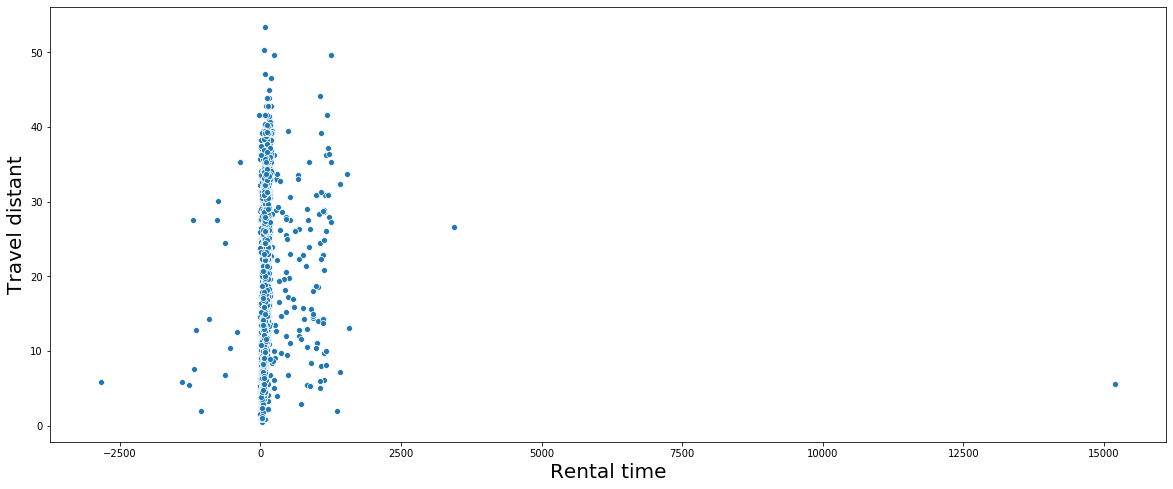

In [25]:
plt.figure(figsize=(20,8))
sns.scatterplot(data = df_new[df_new['PtP'] == 1], x = 'rental_time', y = 'travel_dist')
plt.ylabel('Travel distant', size = 20)
plt.xlabel('Rental time', size = 20)
plt.show()

Dữ liệu xuất hiện những điểm bất thường, cụ thể thời gian thuê xe là âm, và trong số lịch book xe chuyến (point to point), có cuốc xe đi hơn 15000 phút (10 ngày).

In [26]:
df_new['to_date_'].groupby(df_new['travel_type_id']).count()

travel_type_id
1     308
2    4381
3    1118
Name: to_date_, dtype: int64

Cột column to_date_ hiện đang bị missing rất nhiều, hiện tượng missing xảy ra trên cả ba loại hình di chuyển. Trong một số trường hợp, thời gian thuê xe còn bị âm, hoặc quá lớn như trường hợp kể trên. Nếu xem kỹ đối với loại hình di chuyển theo giờ hoặc theo xe dài, cột nhiều mốc thời gian được làm tròn theo ngày (tính vào thời điểm 12h đêm hoặc 8 giờ sáng, giờ bắt đầu làm việc), trong khi đối với các cuốc xe theo chuyến thì thời gian cắt chuyến tính chính xác đến từng giây. Theo đánh giá cá nhân, cột thông tin thuộc tính này quá không đáng tin cậy, nên bị loại bỏ khỏi trường dữ liệu.

In [27]:
df_new[df_new['Long_travel'] == 1]

,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,...,model_id = 64,model_id = 65,model_id = 85,model_id = 86,model_id = 87,model_id = 89,model_id = 90,model_id = 91,rental_time,booking_to_travel
61,model_id = 65,0.0,1,293.0,NaN,0,0,12.849482,77.663187,NaN,...,0,1,0,0,0,0,0,0,965.0,1152
97,model_id = 12,0.0,1,344.0,NaN,0,0,12.947880,77.670920,NaN,...,0,0,0,0,0,0,0,0,5.0,484
202,model_id = 12,0.0,1,1323.0,NaN,0,0,12.869805,77.653211,NaN,...,0,0,0,0,0,0,0,0,1080.0,1896
219,model_id = 12,0.0,1,1063.0,NaN,0,0,12.934477,77.611284,NaN,...,0,0,0,0,0,0,0,0,720.0,1343
236,model_id = 12,0.0,1,1058.0,NaN,0,0,12.914535,77.631658,NaN,...,0,0,0,0,0,0,0,0,2160.0,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853,model_id = 12,0.0,1,393.0,NaN,1,0,13.199560,77.706880,NaN,...,0,0,0,0,0,0,0,0,6.0,596
9928,model_id = 65,0.0,1,393.0,NaN,0,0,13.199560,77.706880,NaN,...,0,1,0,0,0,0,0,0,-14.0,596
9955,model_id = 12,0.0,1,147.0,NaN,1,0,12.977544,77.668800,NaN,...,0,0,0,0,0,0,0,0,NaN,1110
9970,model_id = 12,0.0,1,1136.0,NaN,1,0,12.990490,77.697980,NaN,...,0,0,0,0,0,0,0,0,1445.0,2036


In [28]:
df_new['Weekend'] = np.nan
df_new['Weekend'][(df_new['from_date_'].dt.weekday == 5) | (df_new['from_date_'].dt.weekday == 6)] = 1
df_new['Weekend'].fillna(0, inplace = True)

df_new['Rush_hour'] = np.nan
df_new.set_index(df_new['from_date_'], inplace = True)
df_new['Rush_hour'][df_new.index.isin(df_new.between_time('06:00','09:00').index)] = 1
df_new['Rush_hour'][df_new.index.isin(df_new.between_time('16:00','19:00').index)] = 1
df_new['Rush_hour'].fillna(0, inplace = True)
df_new.reset_index(drop=True, inplace = True)


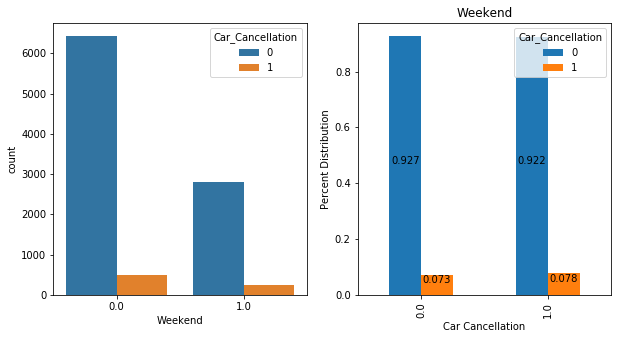

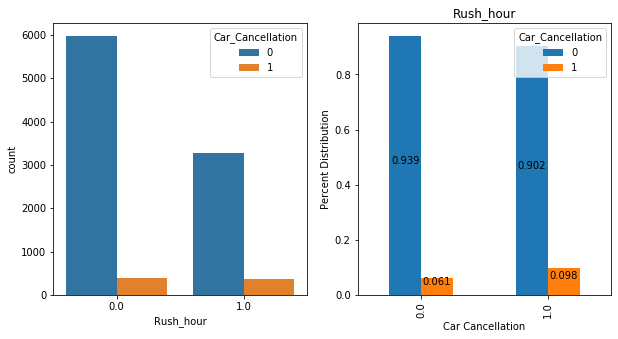

In [29]:
df_cancel_percent = df_new[['Weekend','Rush_hour','Car_Cancellation']]

for i, col in enumerate(df_cancel_percent.columns[:-1]):   
    fig , (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    plt.subplot(ax1)
    sns.countplot(data = df_cancel_percent[[col, 'Car_Cancellation']], x = col, hue = 'Car_Cancellation')
    plt.subplot(ax2)
    ax_1 = pd.crosstab(df_cancel_percent[col], df_cancel_percent['Car_Cancellation'], normalize = 'index').plot.bar(ax = ax2)
    plt.xlabel('Car Cancellation')
    plt.ylabel('Percent Distribution')
    plt.title(df_cancel_percent.columns[i])

    for rec in ax_1.patches:
        height = rec.get_height()
        ax_1.text(rec.get_x() + rec.get_width() / 2, 
                  rec.get_y() + height / 2,
                  "{:.3f}".format(height),
                  ha='center', 
                  va='bottom')

    plt.show()

Weekend có tỉ lệ tài xế cancel hơi cao hơn một chút đối với ngày thường, nhưng tỉ lệ này thể hiện rõ rệt đối với khung thời gian giờ cao điểm. Cụ thể, trong khung giờ cao điểm, tỉ lệ các cuốc xe bị hủy cao hơn gấp rưỡi so với khung giờ bình thường. Điều này dễ dàng hiểu được khi tình trạng kẹt xe, tài xế không đến kịp giờ, tự ý hủy và nhận chuyến xe khác. 

# <a id = '5'> 5. Xử lý tiếp các thuộc tính về tọa độ </a>

Đối với from_area_id và to_area_id, mỗi trường dữ liệu có khoảng 500 phân lớp nên không thể sử dụng one-hot encoding cho tất cả trường dữ liệu này được.

Theo tư duy thông thường, cơ sở hạ tầng và tình trạng giao thông có mức độ ảnh hưởng nhất định đến quá trình ra quyết định của tài xế taxi. Tuy nhiên, dựa vào thuộc tính area_ID, chúng ta không có cách nào có được thông tin này. Do vậy ta sẽ tính gián tiếp thông tin của các vùng đến và đi của tài xế thông qua thuộc tính tọa độ, và phân vùng thành ba vùng (trung tâm mua sắm, nội thành Bangalore, và vùng ngoài thành phố ). Ta thể hiện tọa độ điểm đón và đi trên trục tọa độ.  

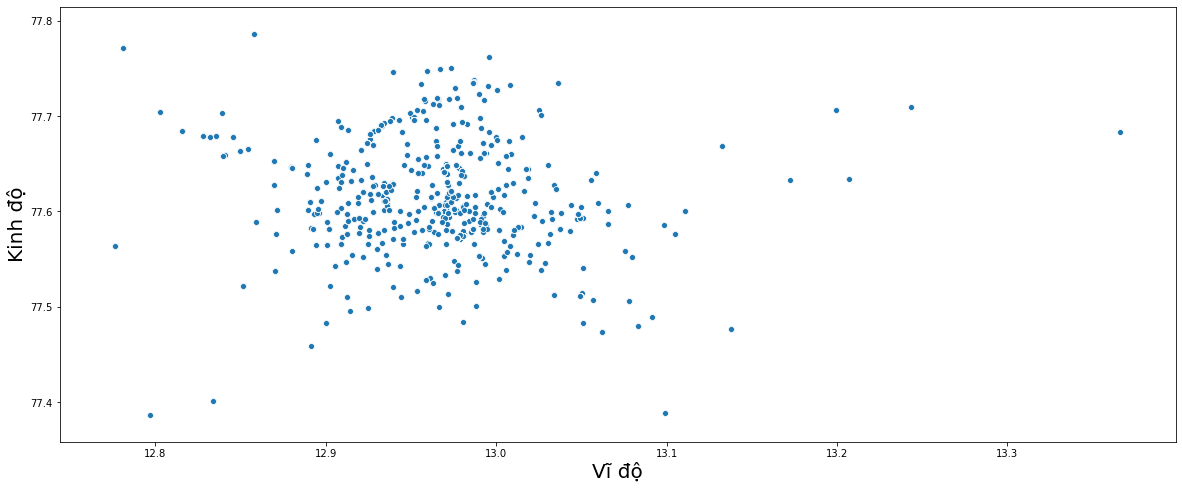

In [30]:
plt.figure(figsize=(20,8))
sns.scatterplot(data = df_new, x = 'from_lat', y = 'from_long')
plt.ylabel('Kinh độ', size = 20)
plt.xlabel('Vĩ độ', size = 20)
plt.show()

Chúng ta thấy tọa độ của các chuyến xe taxi ở điểm đón có sự tập trung xung quanh một tọa độ nhất định. Tra cứu thông tin trên google theo Bangalore Central Business District (CBD), chúng ta có tọa độ của khu CBD, tọa độ này là (12.975, 77.61) và bán kính khoảng 6km. Chúng ta thử vẽ lên trục tọa độ phía trên. 
Ngoài ra diện tích thành phố Bangalore là khoảng 709 km2, trung tâm ở khoảng tọa độ (13.0137758,77.604186), nếu chúng ta tra hình dạng thành phố, thành phố Bangalore cũng tương đối giống hình tròn. Chúng ta cũng thử sử dụng thông số này để vẽ lên đồ thị.

In [31]:
cbd = [12.975, 77.61]
inner = [13.0137758,77.604186]
cbd_radius = 6
inner_radius = np.sqrt(709/np.pi)

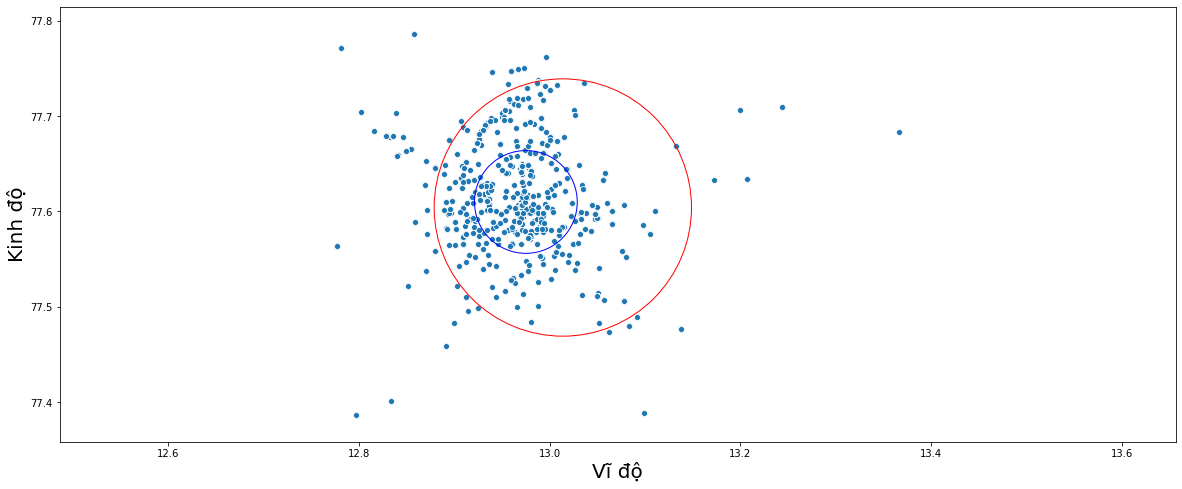

In [32]:
plt.figure(figsize=(20,8))
sns.scatterplot(data = df_new, x = 'from_lat', y = 'from_long')
circle1 = plt.Circle((cbd[0], cbd[1]), cbd_radius/111.32, color='blue', fill=False)
circle2 = plt.Circle((inner[0],inner[1]), inner_radius/111.32, color='r', fill=False)
plt.ylabel('Kinh độ', size = 20)
plt.xlabel('Vĩ độ', size = 20)
plt.gcf().gca().add_artist(circle1)
plt.gcf().gca().add_artist(circle2)
plt.axis('equal')
plt.show()

Ta thấy số lượng đặt xe có sự tập trung ở khu vực CBD, và phần lớn dữ liệu được gói gọn trong phạm vi nội đô thành phố Bangalore. Có thể thấy sử dụng trường thuộc tính tọa độ, chúng ta có thể phân điểm đặt xe taxi thành khu vực CBD, nội đô, và ngoại vi thành phố. Chúng ta sẽ đặt biến category mới, bao gồm 1 nếu thuộc CBD, 2 nếu thuộc nội đô, 3 nếu là ngoại vi, với mức độ yếu dần về cơ sở hạ tầng và lưu lượng giao thông 

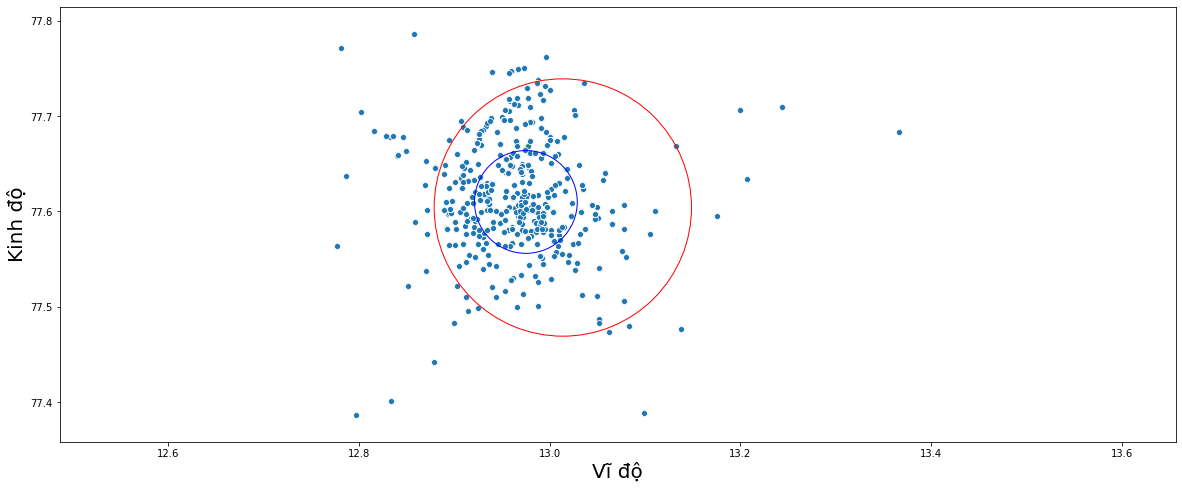

In [33]:
plt.figure(figsize=(20,8))
sns.scatterplot(data = df_new[df_new['to_lat'].notnull()], x = 'to_lat', y = 'to_long')
circle1 = plt.Circle((cbd[0], cbd[1]), cbd_radius/111.32, color='blue', fill=False)
circle2 = plt.Circle((inner[0],inner[1]), inner_radius/111.32, color='r', fill=False)
plt.ylabel('Kinh độ', size = 20)
plt.xlabel('Vĩ độ', size = 20)
plt.gcf().gca().add_artist(circle1)
plt.gcf().gca().add_artist(circle2)
plt.axis('equal')
plt.show()

Điều này cũng đúng đối với các thông tin về tọa độ điểm đến.

In [34]:
def area_dummy(data, x, y):
    data['dist_to_cbd'] = (np.sqrt((data[x] - cbd[0])**2 + (data[y] - cbd[1])**2))*111.32
    data['dist_to_inner'] = (np.sqrt((data[x] - inner[0])**2 + (data[y] - inner[1])**2))*111.32
    return data

In [35]:
area_dummy(df_new, 'from_lat', 'from_long')
df_new['from_area'] = ''
df_new['from_area'][df_new['dist_to_inner'] > inner_radius] = 3
df_new['from_area'][(df_new['dist_to_inner'] <= inner_radius) & (df_new['dist_to_cbd'] > cbd_radius)] = 2
df_new['from_area'][df_new['dist_to_cbd'] <= cbd_radius] = 1

area_dummy(df_new[df_new['to_lat'].notnull()], 'to_lat', 'to_long')
df_new['to_area'] = ''
df_new['to_area'][df_new['dist_to_inner'] > inner_radius] = 3
df_new['to_area'][(df_new['dist_to_inner'] <= inner_radius) & (df_new['dist_to_cbd'] > cbd_radius)] = 2
df_new['to_area'][(df_new['dist_to_cbd'] <= cbd_radius) & (df_new['to_lat'].notnull())] = 1
df_new['to_area'][df_new['to_lat'].isnull()] = 0

In [36]:
df_new.drop(columns = ['dist_to_inner','dist_to_cbd'], axis = 1, inplace = True)

Chúng ta thử vẽ đồ thị tỉ lệ cancellation đối với các biến category mới

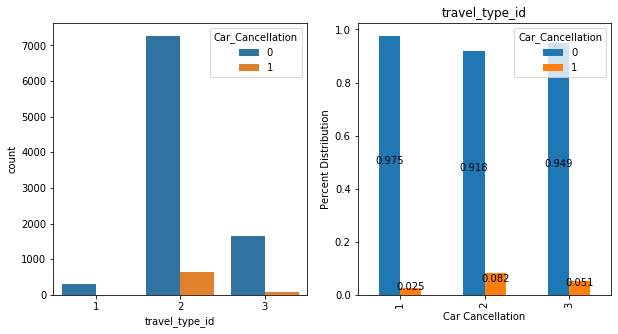

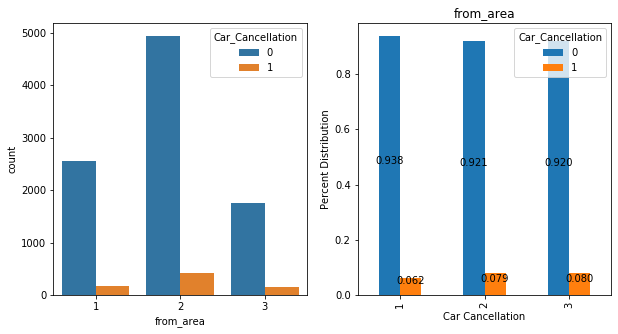

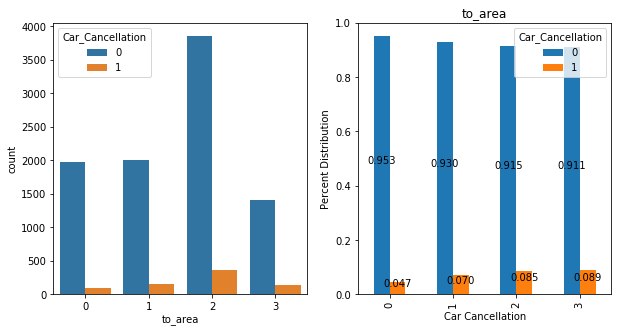

In [37]:
df_cancel_percent = df_new[['travel_type_id','from_area','to_area','Car_Cancellation']]

for i, col in enumerate(df_cancel_percent.columns[:-1]):   
    fig , (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    plt.subplot(ax1)
    sns.countplot(data = df_cancel_percent[[col, 'Car_Cancellation']], x = col, hue = 'Car_Cancellation')
    plt.subplot(ax2)
    ax_1 = pd.crosstab(df_cancel_percent[col], df_cancel_percent['Car_Cancellation'], normalize = 'index').plot.bar(ax = ax2)
    plt.xlabel('Car Cancellation')
    plt.ylabel('Percent Distribution')
    plt.title(df_cancel_percent.columns[i])

    for rec in ax_1.patches:
        height = rec.get_height()
        ax_1.text(rec.get_x() + rec.get_width() / 2, 
                  rec.get_y() + height / 2,
                  "{:.3f}".format(height),
                  ha='center', 
                  va='bottom')

    plt.show()

Sau khi phân loại như trên, chúng ta có thể thấy tỉ lệ cancel của tài xế tăng dần theo các mức category chúng ta đặt ra. Có vẻ như càng ra ngoài khu vực trung tâm, tỉ lệ cancel xe càng tăng lên. 

# <a id = '6'>6. Chuẩn hóa các biến về số, xử lý outlier </a>

Trước khi xem xét về các biến số và xử lý giá trị bất thường, ta loại bỏ các thuộc tính sau khi được biến đổi và kiểm tra missing data lại.

In [38]:
df_new.drop(columns = ['travel_type_id', 'vehicle_model_id', 'from_area_id', 'to_area_id',\
                      'from_lat', 'to_lat', 'from_long', 'to_long',\
                      'from_date_', 'to_date_', 'booking_created_', 'rental_time'], inplace = True)

In [39]:
missing_table(df_new)

,Total missing,Missing percent


Không còn dữ liệu missing.

In [40]:
print(len(df_new[df_new['booking_to_travel']<0]),len(df_new[(df_new['travel_dist'] == 0) & (df_new['PtP'] == 1)]))

8 2


Ta kiểm tra điểm dữ liệu bất thường với booking_to_travel âm (thời gian đặt xe đến khi thời gian di chuyển) và khoảng cách di chuyển là 0 đối với hình thức Point to Point. Chúng ta thấy xuất hiện 8 điểm dữ liệu ở trường hợp trước và 2 điểm dữ liệu bất thường ở trường hợp sau. Kiểm tra cụ thể các trường hợp này, rõ ràng các tài xế có nhận chuyến và di chuyển. Có lẽ đây là lỗi hệ thống, chúng ta loại bỏ những trường hợp này.

In [41]:
df_new[(df_new['travel_dist'] == 0) & (df_new['PtP'] == 1)]

,package_id,online_booking,mobile_site_booking,Car_Cancellation,travel_dist,Long_travel,PtP,Hourly,model_id = 1,model_id = 10,...,model_id = 86,model_id = 87,model_id = 89,model_id = 90,model_id = 91,booking_to_travel,Weekend,Rush_hour,from_area,to_area
4091,0.0,0,0,0,0.0,0,1,0,0,0,...,0,0,0,0,0,386,0.0,1.0,2,2
5268,0.0,0,0,0,0.0,0,1,0,0,0,...,0,0,0,0,0,204,0.0,1.0,1,1


In [42]:
df_new[df_new['booking_to_travel']<0]

,package_id,online_booking,mobile_site_booking,Car_Cancellation,travel_dist,Long_travel,PtP,Hourly,model_id = 1,model_id = 10,...,model_id = 86,model_id = 87,model_id = 89,model_id = 90,model_id = 91,booking_to_travel,Weekend,Rush_hour,from_area,to_area
1188,2.0,0,0,0,-1.000000,0,0,1,0,0,...,0,0,0,0,0,-3,1.0,1.0,2,0
1356,2.0,0,0,0,-1.000000,0,0,1,0,0,...,0,0,0,0,0,-92,0.0,0.0,3,0
2045,0.0,0,0,0,38.335303,0,1,0,0,0,...,0,0,0,0,0,-131,0.0,0.0,3,3
3529,5.0,0,0,0,-1.000000,0,0,1,0,0,...,0,0,0,0,0,-24,1.0,1.0,2,0
3992,0.0,0,0,0,4.089472,0,1,0,0,0,...,0,0,0,0,0,-23,0.0,0.0,2,2
5476,0.0,0,0,0,32.894721,0,1,0,0,0,...,0,0,0,0,0,-5,0.0,0.0,2,2
9106,0.0,0,0,0,5.884210,0,1,0,0,0,...,0,0,0,0,0,-14,0.0,1.0,1,1
9801,0.0,0,0,0,13.468888,0,1,0,0,0,...,0,0,0,0,0,-1374,0.0,0.0,1,1


In [43]:
df_new.drop(df_new[df_new['booking_to_travel'] < 0].index, inplace = True)
df_new.drop(df_new[(df_new['travel_dist'] == 0) & (df_new['PtP'] == 1)].index, inplace = True)

<Figure size 1440x576 with 0 Axes>

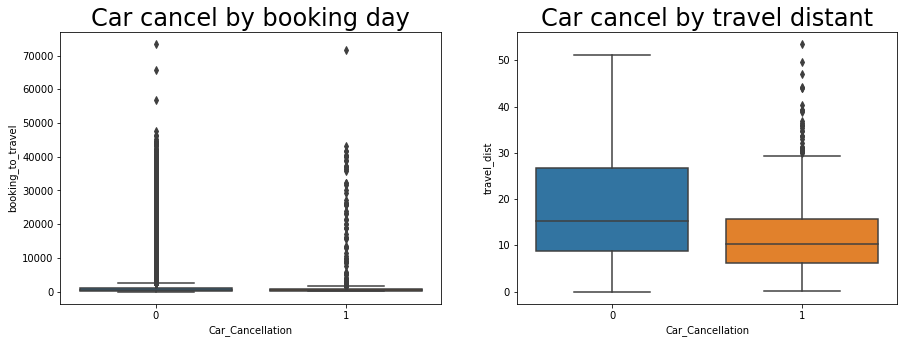

In [44]:
plt.figure(figsize=(20,8))
fig , (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
plt.subplot(ax1)
sns.boxplot(data = df_new, y = 'booking_to_travel', x = 'Car_Cancellation')
plt.title('Car cancel by booking day', size = 24)
plt.subplot(ax2)
sns.boxplot(data = df_new[df_new['PtP'] == 1], y = 'travel_dist', x = 'Car_Cancellation')
plt.title('Car cancel by travel distant', size = 24)
plt.show()

<Figure size 1440x576 with 0 Axes>

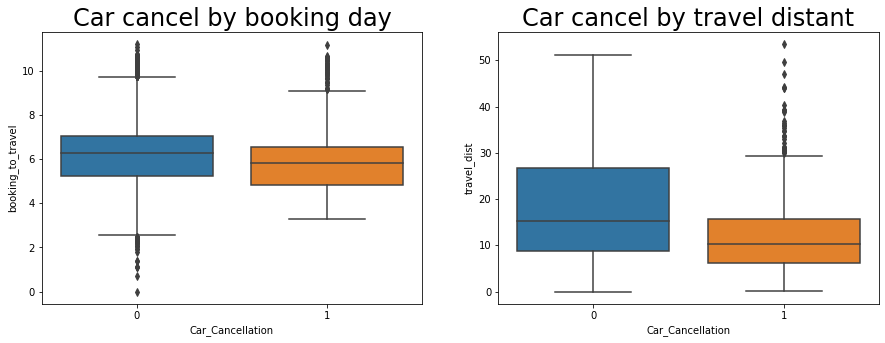

In [45]:
plt.figure(figsize=(20,8))
fig , (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
plt.subplot(ax1)
sns.boxplot(y = np.log(df_new['booking_to_travel']), x = df_new['Car_Cancellation'])
plt.title('Car cancel by booking day', size = 24)
plt.subplot(ax2)
sns.boxplot(data = df_new[df_new['PtP'] == 1], y = 'travel_dist', x = 'Car_Cancellation')
plt.title('Car cancel by travel distant', size = 24)
plt.show()

Đối với Car Cancellation, chúng ta thấy trung bình quãng đường di chuyển của các cuốc xe bị cancel ngắn hơn hẳn các cuốc xe bình thường. Nhưng các trong số các chuyến xe bị cancel, có nhiều điểm dữ liệu bất thường nằm ngoài đầu nến phía trên. Có thể hiểu rằng, các tài xế có vẻ không muốn các chuyến xe ngắn, và cũng không muốn các chuyến xe quá dài. Giá trị điểm bất thường ở đây mang thông tin quan trọng đối với việc ra quyết định của tài xế. Chúng ta không nên loại outlier ở travel_dist.

Đối với biến booking to travel, các điểm bất thường nằm dưới đường nến xảy ra đối với các chuyến xe không bị cancel. Cũng giống như trường hợp của taxi công nghệ, khi tài xế trả khách, họ có thể đón khách tiếp theo luôn, nên khoảng thời gian này sẽ rất ngắn. Và do quãng đường từ khi trả khách trước đến đón khách sau rất gần, nên tài xế sẽ gần như không đưa ra quyết định hủy chuyến. Các điểm bất thường này chứa mang thông tin quan trọng, chúng ta cũng giữ các outlier này lại.

Tuy nhiên, trong tập dữ liệu của chúng ta có các điểm dữ liệu từ khi booking đến khi đi rất dài, chúng ta có thể xử lý bằng cách thay thế một giá trị ở cận trên. Điều này không ảnh hưởng đến dữ liệu của chúng ta. Ở đây chúng ta nếu lấy giá trị cận trên của khoảng 99% dữ liệu, chúng ta có được booking_to_travel xấp xỉ 35000 phút (tương đương 25 ngày).

In [46]:
df_new['booking_to_travel'].quantile(0.99)

35412.30000000001

In [47]:
df_new['booking_to_travel'][df_new['booking_to_travel'] > df_new['booking_to_travel'].quantile(0.99)] = df_new['booking_to_travel'].quantile(0.99)

<Figure size 1440x576 with 0 Axes>

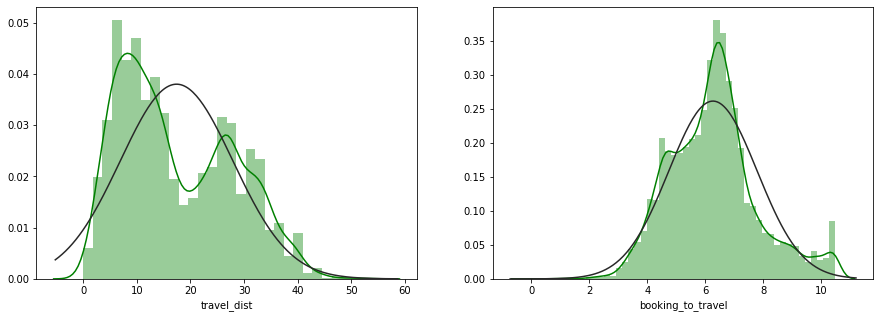

In [48]:
from scipy.stats import norm
plt.figure(figsize=(20,8))
fig , (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
plt.subplot(ax1)
sns.distplot(df_new['travel_dist'][df_new['PtP'] == 1], color = 'g', fit = norm)
plt.subplot(ax2)
sns.distplot(np.log(df_new['booking_to_travel']), color = 'g', fit = norm)
plt.show()

In [49]:
print(df_new['travel_dist'][df_new['PtP'] == 1].skew(),np.log(df_new['booking_to_travel']).skew())

0.4470319441921449 0.46019553284543535


Hai giá trị này đều nhỏ hơn 0.5, cho nên độ lệch của hai thuộc tính này coi như không đáng kể.

In [50]:
df_new['booking_to_travel'] = np.log(df_new['booking_to_travel'])

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
df_new['booking_to_travel'] = scaler.fit_transform(df_new['booking_to_travel'].values.reshape(-1, 1))

data = pd.DataFrame(df_new['travel_dist'][df_new['PtP'] == 1], index = df_new.index)
data['travel_dist_normal'] = scaler.fit_transform(data.values.reshape(-1, 1))
data.drop(columns = 'travel_dist', axis = 1, inplace = True)
df_new = pd.concat([df_new, data], axis = 1)
df_new['travel_dist'][df_new['PtP'] == 1] = df_new['travel_dist_normal'][df_new['PtP'] == 1]
df_new.drop(columns = 'travel_dist_normal', inplace = True)

<Figure size 1440x576 with 0 Axes>

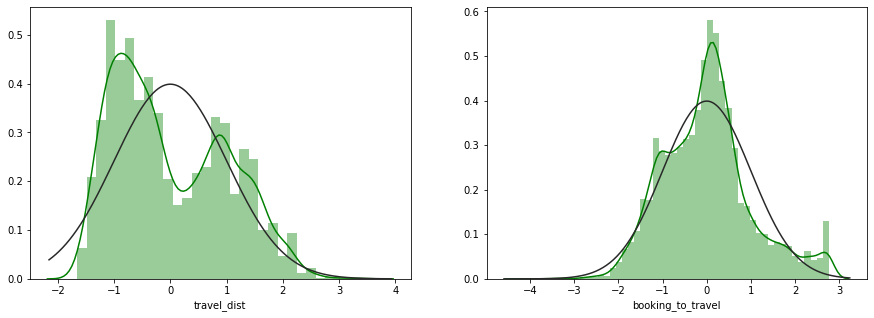

In [52]:
plt.figure(figsize=(20,8))
fig , (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
plt.subplot(ax1)
sns.distplot(df_new['travel_dist'][df_new['PtP'] == 1], color = 'g', fit = norm)
plt.subplot(ax2)
sns.distplot(df_new['booking_to_travel'], color = 'g', fit = norm)
plt.show()

In [53]:
y = df_new['Car_Cancellation']
x = df_new.drop(columns = 'Car_Cancellation', axis = 1)

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1, stratify=y)
print(y_train.sum()/len(y_train), y_test.sum()/len(y_test))

0.07447722715554282 0.07450718342799867


# <a id='7'>7. Mô hình dự đoán với RandomForest </a>

In [55]:
sampler = RandomOverSampler()
x_rs, y_rs = sampler.fit_sample(x_train, y_train)

model_RF = RandomForestClassifier(n_estimators=100)
grid = {   
    'max_depth': [3, 4, 5, 6],
    'max_features': [5, 6],
    'min_samples_leaf': [3, 6],
}
rf = ms.GridSearchCV(estimator=model_RF, param_grid=grid, cv=10, scoring = 'roc_auc')
rf.fit(x_rs, y_rs)

best_depth = rf.best_params_['max_depth']
best_feature = rf.best_params_['max_features']
best_sample_leaf = rf.best_params_['min_samples_leaf']

print(max(rf.cv_results_['mean_test_score']))

0.8598019252361263


In [56]:
from sklearn import metrics
rf.fit(x_rs, y_rs)
y_predict = rf.predict(x_test)
y_predict_prob = rf.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:,1])
metrics.auc(fpr, tpr)

0.7927206941768791

In [57]:
sampler = SMOTE()
x_rs, y_rs = sampler.fit_sample(x_train, y_train)

model_RF = RandomForestClassifier(n_estimators=100)
grid = {   
    'max_depth': [4, 5, 6],
    'max_features': [5, 6],
    'min_samples_leaf': [3, 6],
}
rf = ms.GridSearchCV(estimator=model_RF, param_grid=grid, cv=10, scoring = 'roc_auc')
rf.fit(x_rs, y_rs)

best_depth = rf.best_params_['max_depth']
best_feature = rf.best_params_['max_features']
best_sample_leaf = rf.best_params_['min_samples_leaf']

print(max(rf.cv_results_['mean_test_score']))

0.8635608782883265


In [58]:
y_predict = rf.predict(x_test)
y_predict_prob = rf.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:,1])
metrics.auc(fpr, tpr)

0.783663855207136

In [59]:
model_RF = RandomForestClassifier(n_estimators=100)
grid = {   
    'max_depth': [4, 5, 6],
    'max_features': [5, 6],
    'min_samples_leaf': [3, 6],
}
rf = ms.GridSearchCV(estimator=model_RF, param_grid=grid, cv=10, scoring = 'roc_auc')
rf.fit(x_rs, y_rs)

best_depth = rf.best_params_['max_depth']
best_feature = rf.best_params_['max_features']
best_sample_leaf = rf.best_params_['min_samples_leaf']

print(max(rf.cv_results_['mean_test_score']))

0.8646360226905545


In [61]:
y_predict = rf.predict(x_test)
y_predict_prob = rf.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:,1])
metrics.auc(fpr, tpr)

0.7798538148969583

Kết quả thu được bằng ba cách resample như sau:


| Chọn lại mẫu | AUROC ở tập validation | AUROC ở tập test
| ---|---|---
| Sử dụng thông số tích hợp trong mô hình| 0.864 | 0.779
| Sử dụng chọn lại mẫu đơn giản (naive) | 0.859| 0.792
| Sử dụng chọn lại mẫu SMOTE | 0.863 | 0.783

## <a id='8'>8. Mô hình dự đoán với AdaBoost</a>

In [62]:
sampler = RandomOverSampler()
x_rs, y_rs = sampler.fit_sample(x_train, y_train)

In [63]:
model_ada = AdaBoostClassifier(n_estimators=100)
grid = {   
    'n_estimators': [50, 75, 100, 200],
    'learning_rate': [0.01, 0.1, 0.15, 0.2]    
}
ada = ms.GridSearchCV(estimator=model_ada, param_grid=grid, cv=10, scoring = 'roc_auc')
ada.fit(x_rs, y_rs)

best_n_estimators = ada.best_params_['n_estimators']
best_learning_rate = ada.best_params_['learning_rate']

print(max(ada.cv_results_['mean_test_score']))

0.8346289054111796


In [64]:
y_predict = ada.predict(x_test)
y_predict_prob = ada.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:,1])
metrics.auc(fpr, tpr)

0.7855935633225948

## <a id='9'>9. Mô hình dự đoán với Lightgbm</a>

In [65]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, repeated = 20, n_estimators=1000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, 
                 max_bin, lambda_l1, lambda_l2, learning_rate):
        params = {'application':'binary','num_iterations': n_estimators, 
                  'early_stopping_round':100, 'metric':'auc', 'verbosity' : -1}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['learning_rate'] = learning_rate
        params['max_bin'] = int(round(max_bin))
        cv = KFold(n_splits=10, shuffle = True)
        cv_result = lgb.cv(params, train_data, folds = cv, verbose_eval = 1000, metrics=['auc'])
        return max(cv_result['auc-mean'])
    
    result = pd.DataFrame()
    result['Fold'], result['auc-mean'] = [],[]
    # range 
    for i in range(repeated):
        lgbBO = BayesianOptimization(lgb_eval, { 'feature_fraction': (0.1, 0.9),
                                                 'bagging_fraction': (0.1, 0.9),
                                                 'max_depth': (4,8),
                                                 'num_leaves' : (3,10),
                                                 'max_bin' : (50, 100),
                                                 'lambda_l1': (0, 3),
                                                 'lambda_l2': (0, 3),
                                                 'learning_rate' : (0.005, 0.2)})                                                       
                                            
    # optimize
        lgbBO.maximize(init_points=init_round, n_iter=opt_round)
        result = result.append(lgbBO.max['params'], ignore_index=True)
        result.iloc[i,0] = i+1
        result.iloc[i,1] = lgbBO.max['target']
    # return best parameters
    return result

In [82]:
x_rs['from_area']=x_rs['from_area'].astype('float')
x_rs['to_area']=x_rs['to_area'].astype('float')

In [85]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout  

In [87]:
with HiddenPrints():
    opt_params = bayes_parameter_opt_lgb(x_rs, y_rs, init_round=10, opt_round=25, repeated = 10, n_estimators=10, output_process=False)

In [88]:
best_params = opt_params[opt_params['auc-mean'] == opt_params['auc-mean'].max()]
best_params = best_params.iloc[0,:].to_dict()

params = {'num_leaves' : int(round(best_params['num_leaves'])),
          'learning_rate' : best_params['learning_rate'],                               
          'bagging_fraction' : best_params['bagging_fraction'], 
          'feature_fraction' : best_params['feature_fraction'],
          'lambda_l1' : best_params['lambda_l1'], 'lambda_l2' : best_params['lambda_l2'],
          'max_depth' : int(round(best_params['max_depth'])),
          'num_iterations': 100, 'objective':'binary',
          'metric':'auc', 'verbosity' : -1}

In [90]:
x_test['from_area']=x_test['from_area'].astype('float')
x_test['to_area']=x_test['to_area'].astype('float')

In [91]:
train_data = lgb.Dataset(data = x_rs, label=y_rs, free_raw_data=False)
clf = lgb.train(params=params, train_set = train_data, verbose_eval=False)                     

y_predict = clf.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)
metrics.auc(fpr, tpr)

0.7878300496996973

In [92]:
best_params['auc-mean']

0.8363336107320853